In [1]:
import torch
import pandas as pd

In [2]:
data = pd.read_csv("./datasets/Amazon_Reviews_full-product/amazon_reviews.csv")
data = data.sample(frac=0.5)
data.reset_index(drop=True,inplace=True)

In [3]:
data.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,6135,__label1__,5,N,Sports,B00NL7E0OQ,Attmu 2 Pack Silicone Swim Caps with Ergonomic...,Must Buy! Great Product !,They are reasonably priced and are long lastin...
1,14389,__label2__,2,Y,Beauty,B00ITY6XK0,"Amilean Cellulite Cream Firming Lotion, Anti-F...",If there is anything better bring it on,I don't know if any of those creams really wor...
2,7222,__label1__,5,Y,Apparel,B00LQ1M5GY,MBJ WT590 Womens Long Sleeve Handkerchief Hem ...,This style make me look slimmer!!!,This Made by Johnny-Long Slv Handkerchief Hem ...
3,18461,__label2__,5,N,Video DVD,B00W3S8UI6,Outcasts Surviving the Culture of Rejection DV...,A compelling look at a major societal problem,An excellent examination of one of society's p...
4,1922,__label1__,4,N,Sports,B000HRP7C2,"SPRI Deluxe Vinyl Dumbbells (Dark Blue, 5-Poun...",quality check!,I am eager to achieve my goal.<br />What goal?...


In [4]:
data["label"] = data['LABEL'].replace({"__label1__":1,"__label2__":0})
data = data.drop(columns=["LABEL"])

In [5]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [7]:
data["VERIFIED_PURCHASE"] = data['VERIFIED_PURCHASE'].replace({"N":0,"Y":1})

data["category"] = data["PRODUCT_CATEGORY"] + " [SEP] " + data["PRODUCT_TITLE"]
data = data.drop(columns=["PRODUCT_TITLE","PRODUCT_CATEGORY"])

data["text"] = data["REVIEW_TITLE"] + " [SEP] " + data["REVIEW_TEXT"]
data = data.drop(columns=["REVIEW_TITLE","REVIEW_TEXT"])

data['rating'] = data['RATING']
data = data.drop(columns=['RATING'])

In [8]:
data.head()

,DOC_ID,VERIFIED_PURCHASE,PRODUCT_ID,label,category,text,rating
0,6135,0,B00NL7E0OQ,1,Sports [SEP] Attmu 2 Pack Silicone Swim Caps w...,Must Buy! Great Product ! [SEP] They are reaso...,5
1,14389,1,B00ITY6XK0,0,Beauty [SEP] Amilean Cellulite Cream Firming L...,If there is anything better bring it on [SEP] ...,2
2,7222,1,B00LQ1M5GY,1,Apparel [SEP] MBJ WT590 Womens Long Sleeve Han...,This style make me look slimmer!!! [SEP] This ...,5
3,18461,0,B00W3S8UI6,0,Video DVD [SEP] Outcasts Surviving the Culture...,A compelling look at a major societal problem ...,5
4,1922,0,B000HRP7C2,1,Sports [SEP] SPRI Deluxe Vinyl Dumbbells (Dark...,quality check! [SEP] I am eager to achieve my ...,4


In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [10]:
DEVICE = torch.device("cuda:7")

In [11]:
from torch import Tensor
from torch.nn import Module,Dropout,Linear,Embedding,LayerNorm,BatchNorm1d
from torch.utils.data import DataLoader, Dataset

In [12]:
torch.autograd.set_detect_anomaly(True)

In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

class CategoryReviewDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.stopwords = stopwords.words('english')
        keep = ['not','no','because','but','against','nor','very']
        for elem in keep:
            self.stopwords.remove(elem)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        txt = str(row["rating"]) + " " + row["text"]
        review = [word for word in txt.split() if word.lower() not in self.stopwords]
        label = row["label"]
        category = row["category"]
        # rating = row["rating"]
        
        reviewEncoding = {}
        reviewEncoding['input_ids'] = review
        if len(reviewEncoding['input_ids'])<511:
            reviewEncoding['input_ids'].append("[EOS]")
            reviewEncoding['input_ids'] += ["[PAD]"]*(511-len(reviewEncoding['input_ids']))
        else:
            reviewEncoding['input_ids'] = reviewEncoding['input_ids'][:510]
            reviewEncoding['input_ids'].append("[EOS]")
        reviewEncoding['category'] = category.split()
        if len(reviewEncoding['category'])<82:
            reviewEncoding['category'] += ["[PAD]"]*(82-len(reviewEncoding['category']))
        else:
            reviewEncoding['category'] = reviewEncoding['category'][:82]
        reviewEncoding["label"] = torch.tensor(label)
        return reviewEncoding

[nltk_data] Downloading package stopwords to
[nltk_data]     /raid/home/akshat21515/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def collate_fn(batch):
    text, categories, labels = [], [], []
    for sample in batch:
        text.append(sample['input_ids'])
        categories.append(sample['category'])
        labels.append(sample["label"])

    return text, categories, torch.stack(labels)

In [15]:
class PositionalEncodings(Module):
    def __init__(self, d_model:int, max_len:int=512):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

        pe = torch.zeros((max_len, d_model))
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x:Tensor):
        return (self.pe[:x.size(1), :]).unsqueeze(0)

In [16]:
from typing import Any,Tuple
import torch.nn.functional as F

class FakeReviewIdentifier(Module):
    def __init__(self,
                 model,
                 embeddingLayer,
                 embSize:int,
                 d_model:int,
                 vocabSize:int,
                 num_classes:int,
                 dropoutRate:float,
                 actOut:Any):
        
        super().__init__()
        self.embedding = embeddingLayer
        self.transform = Linear(embSize,d_model)
        self.positionalEncoding = PositionalEncodings(d_model)
        self.vocabSize = vocabSize

        self.model = model
        self.dropout = Dropout(dropoutRate)
        self.layerNorm = LayerNorm(d_model)

        self.fc1 = Linear(d_model,d_model//2)
        self.fc2 = Linear(d_model//2,d_model//4)
        self.fc3 = Linear(d_model//4,num_classes)

        self.act1 = F.tanh
        self.act2 = actOut

    def forward(self, text, category, attnMask):
        x = self.embedding(text)
        x = x.to(DEVICE)
        x = self.transform(x)
        
        xCategory = self.embedding(category)
        xCategory = xCategory.to(DEVICE)
        xCategory = self.transform(xCategory)
        
        x += self.positionalEncoding(x)
        xCategory += self.positionalEncoding(xCategory)

        xOut = self.model(x,xCategory,attnMask)
        xOut = xOut[:,0,:]
        xOut = xOut.to(torch.float32)
        
        out = self.fc1(xOut)
        out = self.fc2(out)
        out = self.act2(out)
        out = self.fc3(out)
        out = torch.softmax(out,dim=-1,dtype=torch.float32)

        return out

In [17]:
train_data = data.sample(frac=0.8)
val_data = data.drop(train_data.index)
test_data = val_data.sample(frac=0.5)

In [18]:
from transformers import AutoTokenizer,AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

train_loader = DataLoader(CategoryReviewDataset(train_data), batch_size=256, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(CategoryReviewDataset(val_data), batch_size=256, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(CategoryReviewDataset(test_data), batch_size=256, shuffle=True, collate_fn=collate_fn)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/raid/home/akshat21515/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
class CategoryAttention(Module):
    def __init__(self,
                 d_model:int=512,
                 n_heads:int=8):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_head"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model//n_heads

        self.Wk = Linear(d_model,d_model)
        self.Wq = Linear(d_model,d_model)
        self.Wv = Linear(d_model,d_model)
        self.Wo = Linear(d_model,d_model)

    def forward(self,query,key,value,mask=None):
        batch_size = query.size(0)

        Q = self.Wq(query)
        K = self.Wk(key)
        V = self.Wv(value)

        Q = Q.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)

        energy = torch.matmul(Q,K.permute(0,1,3,2)) / torch.sqrt(torch.tensor(self.head_dim,dtype=torch.float32))
        if mask is not None:
            energy.masked_fill_(mask==0,float("-1e20"))

        attnWeights = torch.softmax(energy,dim=1)
        out = torch.matmul(attnWeights,V)
        out = out.permute(0,2,1,3).contiguous().view(batch_size,-1,self.d_model)

        out = self.Wo(out)
        return out

In [20]:
class TransformerEncoderLayer(Module):
    def __init__(self,
                 d_model:int=512,
                 n_heads:int=8,
                 dim_feedforward:int=2048,
                 dropout:float=0.1,
                 activation:Any = F.relu_):
        
        super().__init__()
        self.selfAttn = CategoryAttention(d_model,n_heads)
        
        self.fc1 = Linear(d_model,dim_feedforward)
        self.dropout = Dropout(dropout)
        
        self.fc2 = Linear(dim_feedforward,d_model)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)

        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)
        self.dropout3 = Dropout(dropout)
        
        self.activation = activation

    def forward(self,
                sent1:Tensor,
                attnMask:Tensor=None,
                crossAttn:Tensor=None):
        
        attnSet = self.selfAttn(sent1,sent1,sent1,attnMask)
        resConn = self.dropout1(attnSet)
        if crossAttn is not None:
            resConn += self.dropout2(crossAttn)
        normOut = self.norm1(resConn)

        FFNOutp = self.activation(self.fc1(normOut))
        FFNProd = self.fc2(self.dropout(FFNOutp))

        out = resConn + self.dropout3(FFNProd)
        out = self.norm2(out)
        return out

In [21]:
from torch.nn import ModuleList

class TransformerEncoder(Module):
    def __init__(self,
                 encoder_layer:Module,
                 num_layers:int=8,
                 d_model:int=512,
                 n_heads:int=8,
                 dim_feedforward:int=2048,
                 dropout:float=0.1,
                 activation:Any=F.relu_):
        
        super().__init__()
        self.catAttn = CategoryAttention(d_model,n_heads)
        self.layers = ModuleList([encoder_layer(d_model,n_heads,dim_feedforward,dropout,activation) for _ in range(num_layers)])

    def forward(self,
                sent1:Tensor,
                sent2:Tensor,
                mask:Tuple[Tensor]=None):
        out = sent1
        attnCat = self.catAttn(sent1,sent2,sent2,mask[0])
        for layer in self.layers:
            out = layer(out,mask[1],attnCat)
        return out

In [22]:
from gensim.models.fasttext import load_facebook_vectors

def FasttextEmbedding(sentences,model=load_facebook_vectors("cc.en.300.bin")):
    embeds = []
    for sentence in sentences:
        wordEmbeds = []
        for i in range(len(sentence)):
            wordEmbeds.append(torch.tensor(model[sentence[i]]))
        if wordEmbeds:
            sentenceEmbedding = torch.stack(wordEmbeds)
            clsEmbed = torch.mean(sentenceEmbedding,dim=0).unsqueeze_(0)
            if len(sentences[0])==512:
                sentenceEmbedding = torch.cat([clsEmbed,sentenceEmbedding],dim=0)
            embeds.append(sentenceEmbedding)
    return torch.stack(embeds)

In [51]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import torch.nn as nn

embSize = 300
d_model = 128
n_heads = 16
num_layers = 4
num_classes = 2
vocab_size = len(tokenizer)
dropout_rate = 0.25
dim_feedforward = 256
activation = F.relu_

baseModel = TransformerEncoder(
    TransformerEncoderLayer,
    num_layers,
    d_model,
    n_heads,
    dim_feedforward,
    dropout_rate,
    activation
)

model = FakeReviewIdentifier(baseModel,FasttextEmbedding,embSize,d_model,vocab_size,num_classes,dropout_rate,F.leaky_relu_)

param_list = list(model.parameters()) + list(baseModel.parameters())
for param in param_list:
    if param.dim()>1:
        nn.init.xavier_uniform_(param)

optimizer = Adam(param_list, lr=5e-4)
loss_fn = CrossEntropyLoss()

/raid/home/akshat21515/.local/lib/python3.8/site-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)


In [52]:
def generateMask(t1,t2):
    attnMask = []
    for i in range(len(t1)):
        s1 = t1[i]
        curMask = []
        for word in s1:
            if word=="[PAD]":
                curMask.append(0)
            else:
                curMask.append(1)
        s1Mask = torch.tensor(curMask).unsqueeze_(1)

        s2 = t2[i]
        curMask = []
        for word in s2:
            if word=="[PAD]":
                curMask.append(0)
            else:
                curMask.append(1)
        s2Mask = torch.tensor(curMask).unsqueeze_(0)
        attnMask.append(torch.matmul(s1Mask,s2Mask))
    return torch.stack(attnMask).unsqueeze_(1)

In [53]:
def epoch(loader, model, loss_fn, optimizer, is_train:bool=False):
    model.train(is_train)
    total_loss = 0
    total_acc = 0
    for text, category, labels in loader:
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(is_train):
            out = model(text, category, attnMask=(generateMask(text,category).to(DEVICE),generateMask(text,text).to(DEVICE)))
            loss = loss_fn(out, labels)
            _,preds = torch.max(out,dim=1)
            acc = (preds==labels).sum().item()/labels.size(0)
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item()
            total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

In [54]:
torch.cuda.empty_cache()

In [55]:
num_epochs = 100
train_losses, val_losses, train_accs, val_accs = [], [], [], []
patience = 10
min_val_loss = 1e9
bad_epochs = 0

for currEpoch in range(num_epochs):
    model.to(DEVICE)
    
    train_loss,train_acc = epoch(train_loader, model, loss_fn, optimizer, is_train=True)
    val_loss,val_acc = epoch(val_loader, model, loss_fn, optimizer, is_train=False)

    print(f"Epoch {currEpoch+1}")
    print(f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f} | Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        bad_epochs = 0
    else:
        bad_epochs += 1
    if bad_epochs == patience:
        break

Epoch 1
Train Loss: 0.7203 Train Accuracy: 0.5117 | Val Loss: 0.6829 Val Accuracy: 0.5615
Epoch 2
Train Loss: 0.6845 Train Accuracy: 0.5425 | Val Loss: 0.6620 Val Accuracy: 0.5961
Epoch 3
Train Loss: 0.6740 Train Accuracy: 0.5570 | Val Loss: 0.6589 Val Accuracy: 0.5873
Epoch 4
Train Loss: 0.6681 Train Accuracy: 0.5732 | Val Loss: 0.6484 Val Accuracy: 0.6073
Epoch 5
Train Loss: 0.6653 Train Accuracy: 0.5788 | Val Loss: 0.6463 Val Accuracy: 0.6129
Epoch 6
Train Loss: 0.6643 Train Accuracy: 0.5816 | Val Loss: 0.6514 Val Accuracy: 0.5966
Epoch 7
Train Loss: 0.6652 Train Accuracy: 0.5752 | Val Loss: 0.6450 Val Accuracy: 0.6070
Epoch 8
Train Loss: 0.6594 Train Accuracy: 0.5837 | Val Loss: 0.6437 Val Accuracy: 0.6237
Epoch 9
Train Loss: 0.6612 Train Accuracy: 0.5892 | Val Loss: 0.6449 Val Accuracy: 0.6179
Epoch 10
Train Loss: 0.6573 Train Accuracy: 0.5964 | Val Loss: 0.6426 Val Accuracy: 0.6148
Epoch 11
Train Loss: 0.6564 Train Accuracy: 0.6063 | Val Loss: 0.6381 Val Accuracy: 0.6255
Epoch 12

In [56]:
torch.save(model,"checkpoints/FakeClassifier.pt")

In [57]:
cpt = torch.load("checkpoints/FakeClassifier.pt")
newModel = FakeReviewIdentifier(baseModel,FasttextEmbedding,embSize,d_model,vocab_size,num_classes,dropout_rate,F.leaky_relu_)
newModel.load_state_dict(cpt.state_dict())

<All keys matched successfully>

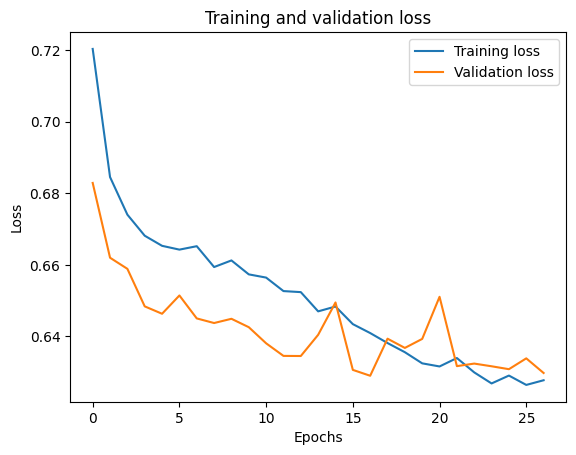

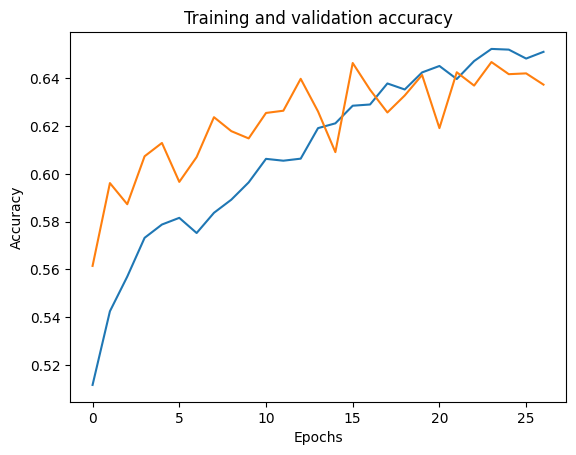

In [61]:
import matplotlib.pyplot as plt


plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()